* Romain Pous, 2021
* Computes steric height for ARGO datas
* Computes altimetry height for aviso datas
* Makes a comparaison between for multiple ARGO profilers

In [1]:
#To deal with data
import xarray as xr
import gsw
import seawater as sw
import os

#For basic calculus
import numpy as np
import numpy.ma as ma
from math import ceil
import scipy.stats as ss

#For the plots
import matplotlib.pyplot as plt
import pylab as plot

params = {'legend.fontsize': 20,
          'legend.handlelength': 2,
          'axes.titlesize' : 24,
          'axes.labelsize' : 20,
          'lines.linewidth' : 3,
          'lines.markersize' : 10,
          'xtick.labelsize' : 20,
          'ytick.labelsize' : 20}

plot.rcParams.update(params)

#To deal with exemple
import random

#For the plots
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

import pylab as plot
params = {'legend.fontsize': 20,
          'legend.handlelength': 2,
          'axes.titlesize' : 24,
          'axes.labelsize' : 20,
          'lines.linewidth' : 3,
          'lines.markersize' : 10,
          'xtick.labelsize' : 20,
          'ytick.labelsize' : 20}

plot.rcParams.update(params)

#the path where all data are stored
path_occiput_obs='/mnt/pousr/old-equipes/IGE/meom/MODEL_SET/ORCA025.L75/ORCA025.L75-OCCITENS/OBS'
#the specific path where data are extracted for year 2010
path_detar=path_occiput_obs+'/OBS-enact_y2010'
#the path to the file for one run (the 1st)
one_file=path_detar+'/ORCA025.L75-OCCITENS.001_y2010_enact_fdbk.nc'

#opening one file
ds_one=xr.open_dataset(one_file,decode_times=False)

In [2]:
def Map(ds,max_lat,min_lat,max_long,min_long):
    """Mapping function. It plots ARGO profilers for a selected area and gives station identifier.
        - ds is the opened file where your ARGO data set is,
        - others parameters are needed for are selection."""
    fig=plt.figure(figsize=(20,15))
    ax = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=0))
    ax.set_extent((max_long,min_long,min_lat, max_lat))
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                              alpha=0.5)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.tick_params('both',labelsize=22)
    plt.title('ARGO profilers between 10°-60°N and 10°-60°O in 2010')
    
    a = []#liste des identifiants
    num=np.where(ds.STATION_TYPE==b' 831')
    colors=cm.viridis(np.linspace(0,1,365))
    n_profiler=len(num[0])
    for j in range(n_profiler):
        ind=np.where(ds.STATION_IDENTIFIER==ds.STATION_IDENTIFIER[num[0][j]])
        if num[0][j]==ind[0][0]:
            one_profile_lon=ds.LONGITUDE[num[0][j]]
            one_profile_lat=ds.LATITUDE[num[0][j]]
            if (one_profile_lat>min_lat and one_profile_lat<max_lat and one_profile_lon>min_long and one_profile_lon<max_long):
                a = np.append(a, num[0][j]) #liste des identifiants
                n=len(ind[0])
                i=0
                one_profile_lon=ds.LONGITUDE[ind[0][i]]
                one_profile_lat=ds.LATITUDE[ind[0][i]]
                plt.scatter(one_profile_lon,one_profile_lat,c='k',linewidth=2, s=25,
                transform=ccrs.PlateCarree(),zorder=1) 
    
    plt.colorbar(label='Days')
    plt.clim(10,365)
    
    print('Argo Identifiers in the area are : ',a)
    print('There are ',len(a),'Argo station(s)')
    
    return a

In [3]:
def selec_one_argo_one_year_all_runs(station,year):
    """File selection function. It selects all datas for a profiler from one year.
        - station is the station identifier,
        - year is the year selected."""
    #first run first
    path=path_occiput_obs+'/OBS-enact_y'+str(year)
    file1=path+'/ORCA025.L75-OCCITENS.001_y'+str(year)+'_enact_fdbk.nc'
    ds1=xr.open_dataset(file1,decode_times=False)
    stations=ds1.STATION_IDENTIFIER
    ind=np.where(stations==station)
    ds1_argo_selec=ds1.sel(N_OBS=ind[0]) 

    return ds1_argo_selec
    
    
def selec_one_argo_years_all_runs(station,year1,year2):
    """File selection function. It selects all datas for a profiler for 3 years.
        - station is the station identifier,
        - years are the years selected."""
    #first year first
    ds_concat=selec_one_argo_one_year_all_runs(station,year1)
    #loop on the other years
    for year in np.arange(year1+1,year2+1):
        ds=selec_one_argo_one_year_all_runs(station,year)
        ds_concat=xr.concat([ds_concat,ds],dim='N_OBS')

    #write on disk
    stat=str(station.values)
    str_stat=stat[2:10]
    ds_concat.to_netcdf('/mnt/pousr/old-equipes/IGE/meom/workdir/pousr/ARGO/selec_profiles'+str(str_stat)+'_y'+str(year1)+'-'+str(year2)+'_r1-50.nc')

# Path to datas

We need to select 3 years for our study. It corresponds to the lifetime of an ARGO profiler.

In [4]:
path_detar0=path_occiput_obs+'/OBS-enact_y2010'
#the path to the file for one run (the 1st)
one_file0=path_detar0+'/ORCA025.L75-OCCITENS.001_y2010_enact_fdbk.nc'
#opening one file
ds_0=xr.open_dataset(one_file0,decode_times=False)

path_detar1=path_occiput_obs+'/OBS-enact_y2011'
#the path to the file for one run (the 1st)
one_file1=path_detar1+'/ORCA025.L75-OCCITENS.001_y2011_enact_fdbk.nc'
#opening one file
ds_1=xr.open_dataset(one_file1,decode_times=False)

path_detar2=path_occiput_obs+'/OBS-enact_y2012'
#the path to the file for one run (the 1st)
one_file2=path_detar2+'/ORCA025.L75-OCCITENS.001_y2012_enact_fdbk.nc'
#opening one file
ds_2=xr.open_dataset(one_file2,decode_times=False)

We call here our Map function to indentify profiler in our area

Argo Identifiers in the area are :  [1.09000e+02 2.19000e+02 3.95000e+02 4.19000e+02 4.53000e+02 7.54000e+02
 1.19600e+03 1.38700e+03 1.41000e+03 1.41600e+03 1.42600e+03 1.96100e+03
 2.04300e+03 2.07400e+03 2.19500e+03 2.27500e+03 2.29000e+03 2.50200e+03
 2.70100e+03 2.71100e+03 2.79900e+03 2.91900e+03 2.92300e+03 3.06400e+03
 3.58200e+03 3.74600e+03 3.90100e+03 3.95600e+03 4.26700e+03 4.27400e+03
 4.37100e+03 4.63100e+03 4.89900e+03 4.92100e+03 5.04500e+03 5.10600e+03
 5.25100e+03 5.30600e+03 5.54600e+03 5.54700e+03 5.57700e+03 5.58800e+03
 5.61900e+03 5.65900e+03 5.66300e+03 5.92200e+03 6.26000e+03 6.26300e+03
 6.68600e+03 6.73100e+03 7.26400e+03 7.30000e+03 7.67000e+03 7.83000e+03
 8.21300e+03 8.55100e+03 9.23200e+03 9.95800e+03 9.96400e+03 1.05120e+04
 1.17810e+04 1.22830e+04 1.42860e+04 1.71690e+04 1.73360e+04 1.76200e+04
 1.82100e+04 1.93470e+04 2.53240e+04 2.60450e+04 2.65720e+04 2.71490e+04
 2.77110e+04 3.34430e+04 3.71580e+04 4.24770e+04 4.68980e+04 4.85380e+04
 4.89660e+04 4.

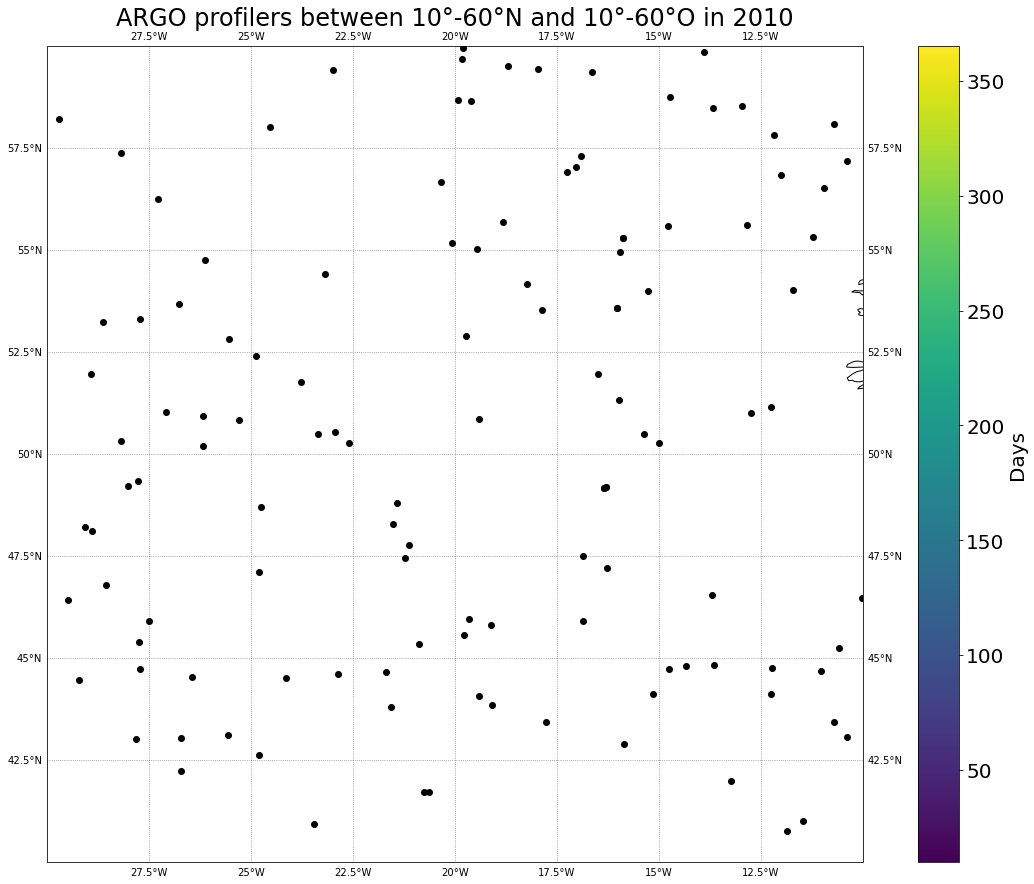

In [5]:
N_ARGO=Map(ds_0,60,40,-10,-30)

###### List of profiler deployed in 2010 in our area :

In [40]:
len(N_ARGO)

124

###### Are profilers working in 2011 ? in 2012 ?

We need how many profilers deployed in 2010 are still working in 2012.

In [90]:
L=np.zeros(len(N_ARGO))
J=np.zeros(len(N_ARGO))
N_ARGO_2010=np.zeros(len(N_ARGO))
for j in range (len(N_ARGO)):
    N_ARGO_2010[j]=N_ARGO[j]
for j in range (len(N_ARGO)):
    ind=np.where(ds_one.STATION_IDENTIFIER==ds_one.STATION_IDENTIFIER[int(N_ARGO[j])])
    L[j]=len(ds_one.JULD[ind[0]])
    if L[j]>30:
        N_ARGO_2010[j]=0
liste_2010=np.where(N_ARGO_2010>0)

N_ARGO_2011=[]             
for j in range(len(N_ARGO[liste_2010])):
    if ds_0.STATION_IDENTIFIER[int(N_ARGO[liste_2010][j])] in ds_1.STATION_IDENTIFIER:
        N_ARGO_2011=np.append(N_ARGO_bis,N_ARGO[liste_2010][j])
        
N_ARGO_2012=[]    
for j in range(len(N_ARGO_2011)):
    if ds_0.STATION_IDENTIFIER[int(N_ARGO_2011[j])] in ds_2.STATION_IDENTIFIER:
        N_ARGO_2012=np.append(N_ARGO_2012,N_ARGO_2011[j])
len(N_ARGO_2012)

72

###### Selection loop

We can now create our files for each profilers and for 3 years

In [44]:
stations=ds_0.STATION_IDENTIFIER
for i in range(len(N_ARGO_tier)):
    stat=stations[int(N_ARGO_tier[i])]
    selec_one_argo_years_all_runs(stat,2010,2012)

### STERIC HEIGHT

In [7]:
def verification(ds,i):
        """Verification function. It identifies uncorrupted levels.
        - ds is the opened file where your ARGO data set is
        - L is the number of levels for a profile. It's often written as len(ds.DEPTH)
        - i is the i-th cycle of the profiler 
        - ind is an array of uncorrupted levels for one profile"""
        ind=[]
        ind=np.where(ds.PSAL_OBS[i]!=99999.0)
        return ind

In [8]:
class Profiler:
    """Profiler class.
    -self.JULD is an array for date of each cycle,
    -self.PSAL_OBS is a salinity array for each cycle and each depth,
    -self.POTM_OBS is a temperature array for each cycle and each depth,
    -self.DEPTH is an array with depths,
    -self.LATITUDE and self.LONGITUDE"""
    def __init__(self, file = None, **kwargs):
        """init methode for our class Profiler.
        -File can be filled with the path of a file to copy ARGO datas from ARGO dataset.
        Otherwise, Profiler will represent a random profiler.
        -csr can be filled to compute steric height."""

        csr=kwargs.get('csr', None)
        alt=kwargs.get('alt', None)
        
        if file is not None:
            self.readfile(file)
        else:
            self.create_random_profile()
                
        if csr is not None: 
            self.steric_height = self.compute_steric_height()
        else:
            self.steric_height='Oops, please ask to compute steric height.'
            
        if alt is not None: 
            self.altimetry_height = self.compute_altimetry_height()
        else:
            self.altimetry_height='Oops, please ask to compute altimetry height.'
                
    def readfile(self,file):
        """Open and read file for an ARGO profiler.
        -Return an error if file doesn't exist or extract datas from an ARGO dataset."""
        # verifie que le fichier existe   
        filexist=os.path.isfile(file)
        if filexist == False:
            self.print_error('nofile')
        else:
            ds_argo=xr.open_dataset(file,decode_times=False) 
            # on ouvre, on lit le fichier
            self.JULD=ds_argo.JULD
            self.PSAL_OBS=ds_argo.PSAL_OBS
            self.POTM_OBS=ds_argo.POTM_OBS
            self.DEPTH=ds_argo.DEPTH
            self.LATITUDE=ds_argo.LATITUDE
            self.LONGITUDE=ds_argo.LONGITUDE
            
    def create_random_profile(self):
        """ Create a random profile to compute and test steric height function."""
        n_cycle=100
        n_level=150
        self.JULD=np.ones(n_cycle)
        self.PSAL_OBS=99999.0*np.ones((n_cycle,n_level))
        self.POTM_OBS=99999.0*np.ones((n_cycle,n_level))
        self.DEPTH=99999.0*np.ones((n_cycle,n_level))
        self.LATITUDE=np.ones(n_cycle)
        self.LONGITUDE=np.ones(n_cycle)
        for i in range(n_cycle):
            self.JULD[i]=i*10
            self.LATITUDE[i]=random.uniform(23, 26)
            self.LONGITUDE[i]=random.uniform(-33, -27)
            for j in range(n_level-50):
                self.PSAL_OBS[i][j]=random.uniform(35.5, 36)
                self.POTM_OBS[i][j]=random.uniform(5, 7)+random.uniform(-0.01, +0.05)
                self.DEPTH[i][j]=j*200+random.uniform(-2,2)
    
    
    def compute_steric_height(self):
        """Compite steric height for a profiler over time. 
        - self is the opened file that contains ARGO data set,
        - H[0] is an array of steric height in meter filled with steric height for each time step."""
        #Number of ARGO cycle
        n_cycle=len(self.JULD)
        #Number of ARGO levels for a profiler.
        n_level=len(self.DEPTH[0])
        #Gravitational constant 
        g=9.81
        #Pressure reference
        pref=1400
        bias=0.000011
        #H is our steric height matrix
        H=[]
        

        #Initialisation : we need this step to create our H matrix
        IND=verification(self,0)
        Length=len(IND[0])
        C_Ps=np.zeros(Length)
        C_SA=np.zeros(Length)
        C_CT=np.zeros(Length)
        C_H=np.zeros(n_level)
        
        if bias is not None:
            H_b=[]
            C_SA_b=np.zeros(Length)
            C_CT_b=np.zeros(Length)
            C_H_b=np.zeros(n_level)

        for j in range (Length):
            #Conversion depth in sea pressure
            C_Ps[j]=sw.eos80.pres(self.DEPTH[0][IND[0][j]],self.LATITUDE[0])
            #Conversion practical salinity in absolute salinity
            C_SA[j]=gsw.SA_from_SP(self.PSAL_OBS[0][IND[0][j]], C_Ps[j], self.LONGITUDE[0], self.LATITUDE[0])
            #Conversion in situ temperature in absolute temperature
            C_CT[j]=gsw.CT_from_t(C_SA[j], self.POTM_OBS[0][IND[0][j]], C_Ps[j])
            if bias is not None :
                C_SA_b[j]=gsw.SA_from_SP(self.PSAL_OBS[0][IND[0][j]], C_Ps[j], self.LONGITUDE[0], self.LATITUDE[0])
                C_CT_b[j]=gsw.CT_from_t(C_SA_b[j], self.POTM_OBS[0][IND[0][j]], C_Ps[j])
        C_H=gsw.geo_strf_dyn_height(C_SA,C_CT,C_Ps,pref)/g  
        if bias is not None :
            C_H_b=gsw.geo_strf_dyn_height(C_SA_b,C_CT_b,C_Ps,pref)/g 
        while len(C_H)<n_level:
            C_H=np.append(C_H,0)
            if bias is not None :
                C_H_b=np.append(C_H_b,0)
        H=C_H
        if bias is not None :
            H_b=C_H_b

        #Steric height loop
        for i in range(n_cycle-1):
            IND=verification(self,i+1)
            Length=len(IND[0])
            C_Ps=np.zeros(Length)
            C_SA=np.zeros(Length)
            C_CT=np.zeros(Length)
            C_H=np.zeros(n_level)
            if bias is not None:
                C_SA_b=np.zeros(Length)
                C_CT_b=np.zeros(Length)
                C_H_b=np.zeros(n_level)
                t=self.JULD[i]-self.JULD[0]
            for j in range (Length):
                #Conversion depth in sea pressure
                C_Ps[j]=sw.eos80.pres(self.DEPTH[i+1][IND[0][j]],self.LATITUDE[i+1])
                #Conversion practical salinity in absolute salinity
                C_SA[j]=gsw.SA_from_SP(self.PSAL_OBS[i+1][IND[0][j]], C_Ps[j], self.LONGITUDE[i+1], self.LATITUDE[i+1])
                #Conversion in situ temperature in absolute temperature
                C_CT[j]=gsw.CT_from_t(C_SA[j], self.POTM_OBS[i+1][IND[0][j]], C_Ps[j])
                if bias is not None :
                    C_SA_b[j]=gsw.SA_from_SP(self.PSAL_OBS[i+1][IND[0][j]]+t*bias, C_Ps[j], self.LONGITUDE[i+1], self.LATITUDE[i+1])
                    C_CT_b[j]=gsw.CT_from_t(C_SA_b[j], self.POTM_OBS[i+1][IND[0][j]], C_Ps[j])
    
            C_H=gsw.geo_strf_dyn_height(C_SA,C_CT,C_Ps,pref)/g
            if bias is not None :
                C_H_b=gsw.geo_strf_dyn_height(C_SA_b,C_CT_b,C_Ps,pref)/g 
            while len(C_H)<n_level:
                C_H=np.append(C_H,0)
                if bias is not None :
                    C_H_b=np.append(C_H_b,0)
            H=np.c_[H, C_H]
            if bias is not None :
                H_b=np.c_[H_b, C_H_b]
        
        if bias is not None :
            return H[0],H_b[0]
        else :
            return H[0]
    
    def compute_altimetry_height(self):
        """Compite altimetry height anomaly for a profiler over time. 
        - self is the opened file that contains ARGO data set,
        - H_alt is an array of altimetry height colocalized for an ARGO profiler."""
        one_file_alt='/home/pousr/Work/dataset-duacs-rep-global-merged-allsat-phy-l4_1636388010406.nc'
        ds_alt=xr.open_dataset(one_file_alt,decode_times=False)
        l=len(self.JULD)
        D=np.zeros(l)
        Lat=np.zeros(l)
        Long=np.zeros(l)
        Time=np.zeros(l)
        A=np.zeros(l)
        B=np.zeros(l)
        H_alt=np.zeros(l)
        for i in range(l):
            one_lat=self.LATITUDE[i]
            D[i]=ceil(one_lat * 10000) / 10000.0
            B[i]=D[i]-int(D[i])
    
            if B[i]<=0.25:
                Lat[i]=int(D[i])+0.125
            elif B[i]>0.25 and B[i]<=0.5:
                Lat[i]=int(D[i])+0.375
            elif B[i]>0.5 and B[i]<=0.75:
                Lat[i]=int(D[i])+0.625
            elif B[i]>0.75:
                Lat[i]=int(D[i])+0.875
        
            one_long=self.LONGITUDE[i]
            if one_long>0:
                D[i]=ceil(one_long * 10000) / 10000.0
                B[i]=D[i]-int(D[i])
                if B[i]<=0.25:
                    Long[i]=int(D[i])+0.125
                elif B[i]>0.25 and B[i]<=0.5:
                    Long[i]=int(D[i])+0.375
                elif B[i]>0.5 and B[i]<=0.75:
                    Long[i]=int(D[i])+0.625
                elif B[i]>0.75:
                    Long[i]=int(D[i])+0.875
            
            if one_long<=0:
                D[i]=ceil(one_long * 10000) / 10000.0
                B[i]=int(D[i])-D[i]
                if B[i]<=0.25:
                    Long[i]=int(D[i])-0.125
                elif B[i]>0.25 and B[i]<=0.5:
                    Long[i]=int(D[i])-0.375
                elif B[i]>0.5 and B[i]<=0.75:
                    Long[i]=int(D[i])-0.625
                elif B[i]>0.75:
                    Long[i]=int(D[i])-0.875

        for i in range (l):
            Time[i]=ceil(self.JULD[i]-self.JULD[0])
            ind_time=np.where(ds_alt.time-ds_alt.time[0]==Time[i])
            ind_lat=np.where(ds_alt.latitude==Lat[i])
            ind_long=np.where(ds_alt.longitude==Long[i])
            H_alt[i]=ds_alt.sla[ind_time[0][0]][ind_lat[0][0]][ind_long[0][0]]
        
        return H_alt        
    
    def print_error(self, errtype):
        if errtype == 'nofile':
            print('Oops, the file does not exist. Please double check.')

###### Plot

In [9]:
P=[]
for i in range(14):
    print(i)
    station=ds_0.STATION_IDENTIFIER[int(N_ARGO_tier[i])]
    stat=str(station.values)
    str_stat=stat[2:10]
    onefile='/mnt/pousr/old-equipes/IGE/meom/workdir/pousr/ARGO/selec_profiles'+str(str_stat)+'_y2010-2012_r1-50.nc'
    rec={'csr':1,'alt':1}
    P.append(Profiler(file=onefile,**rec))

0
1
2
3
4
5
6
7
8
9
10
11
12
13


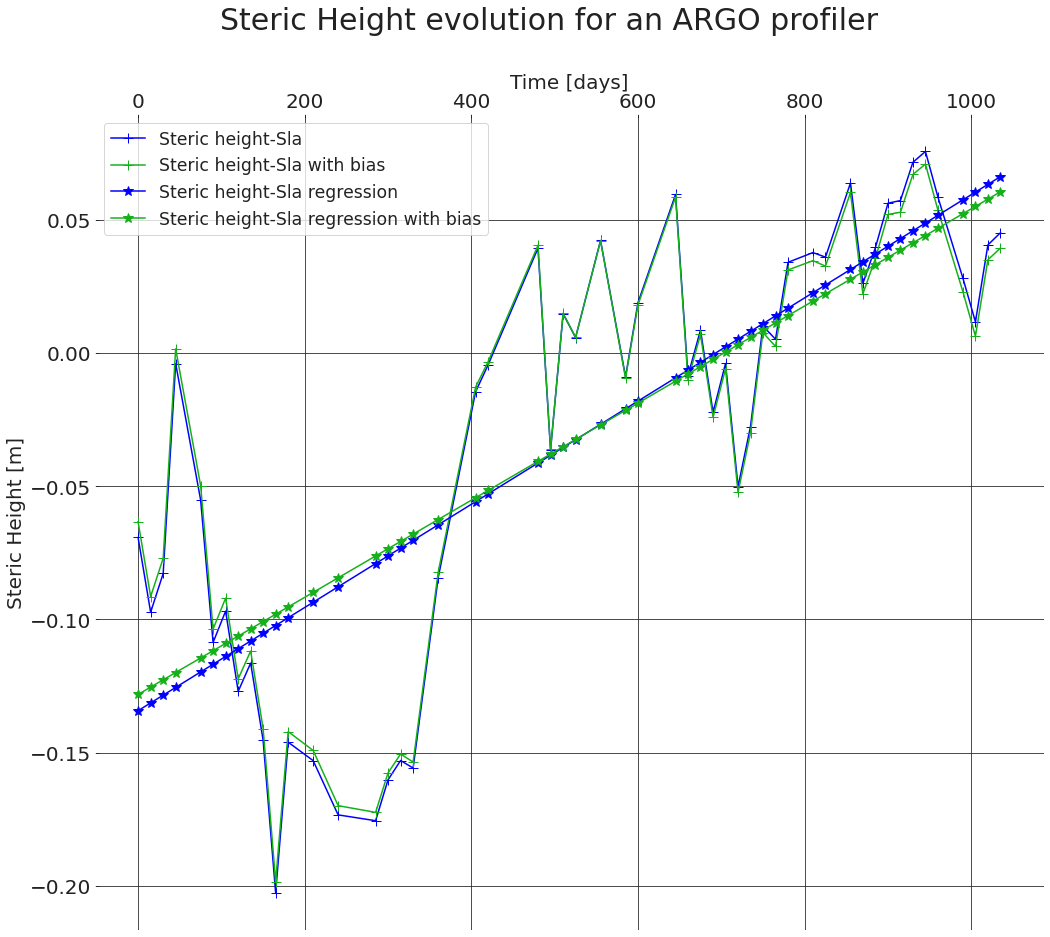

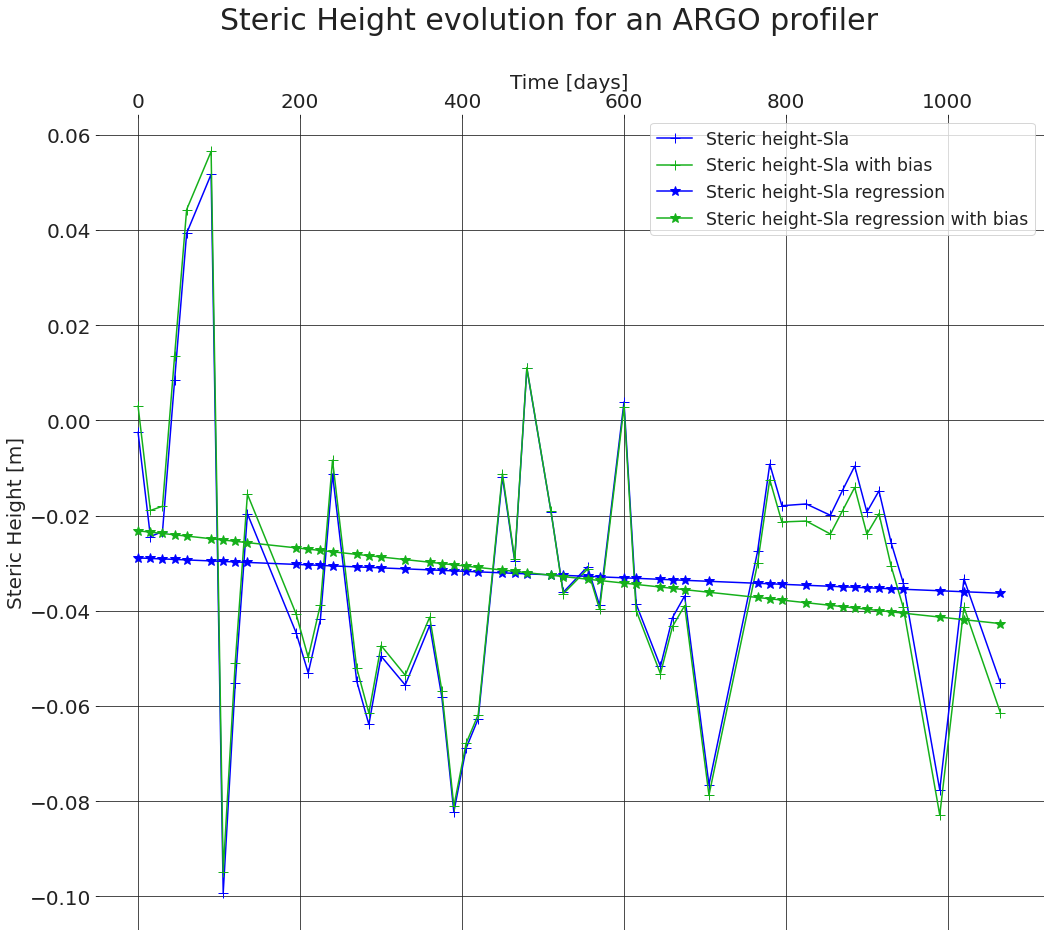

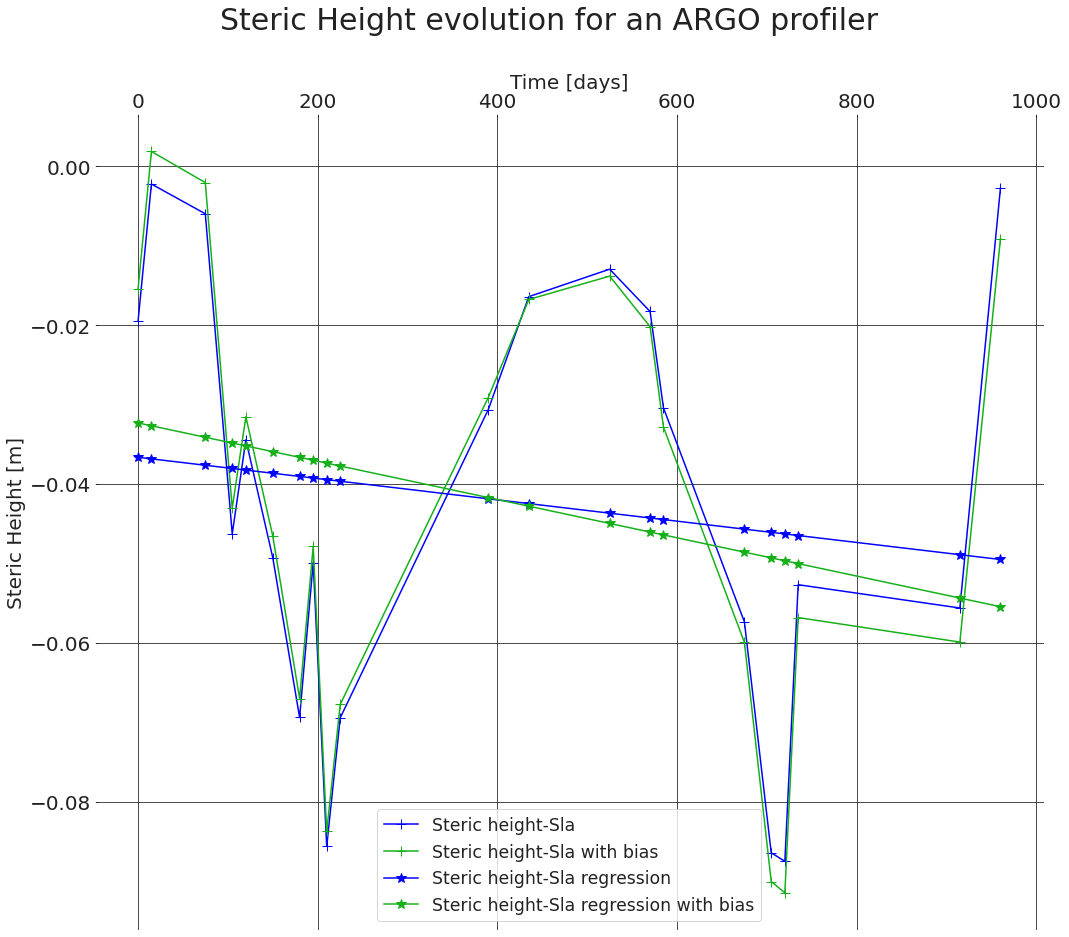

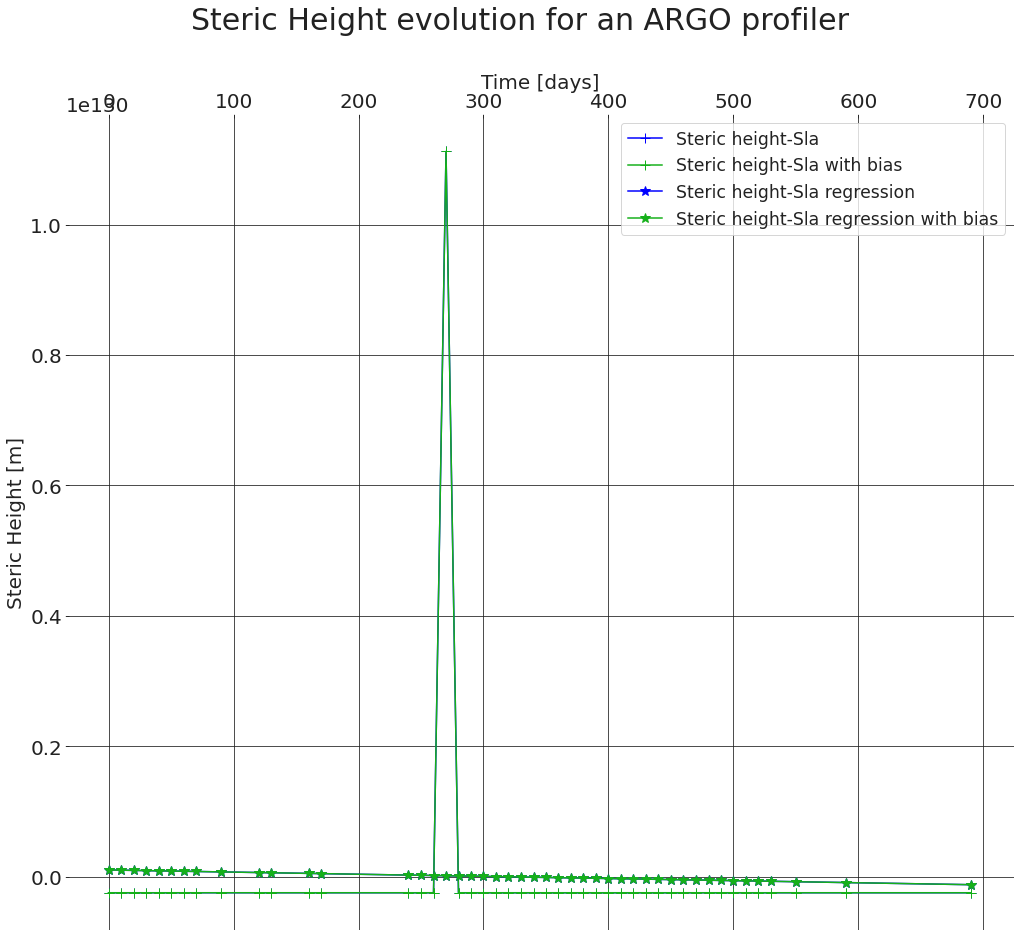

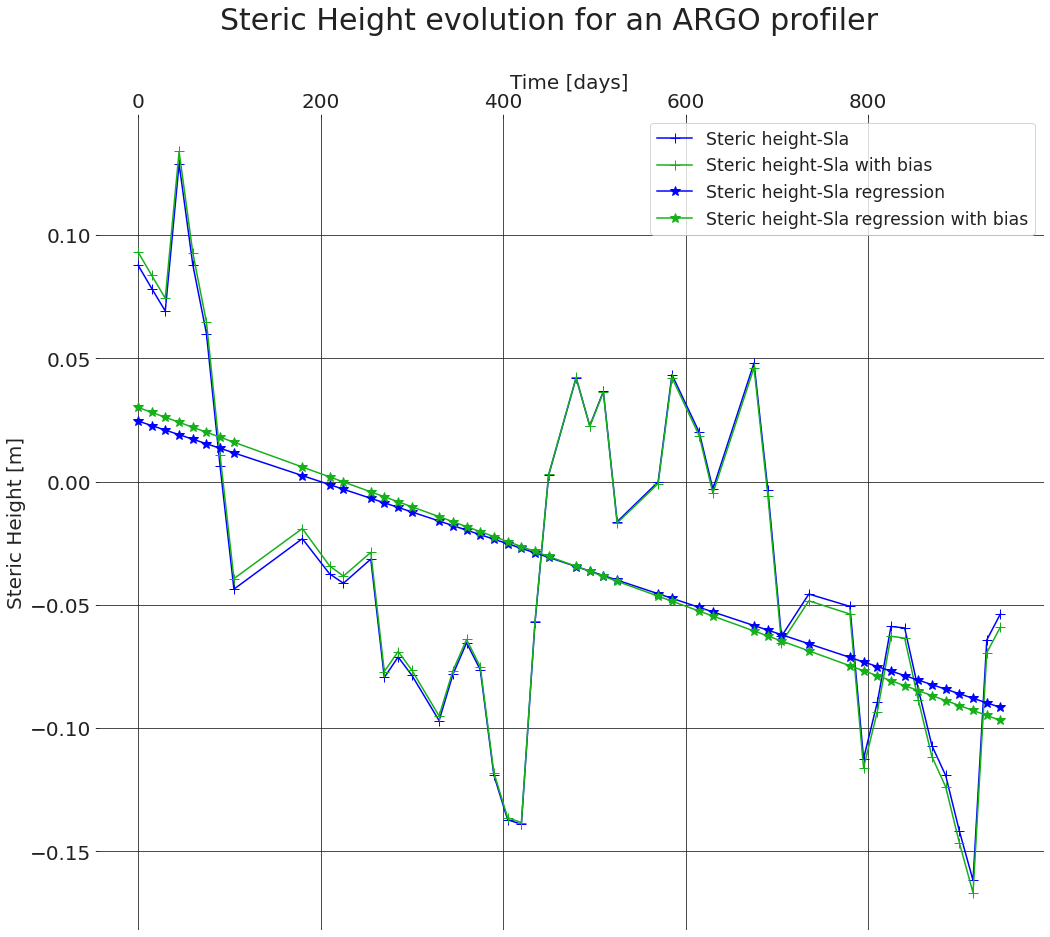

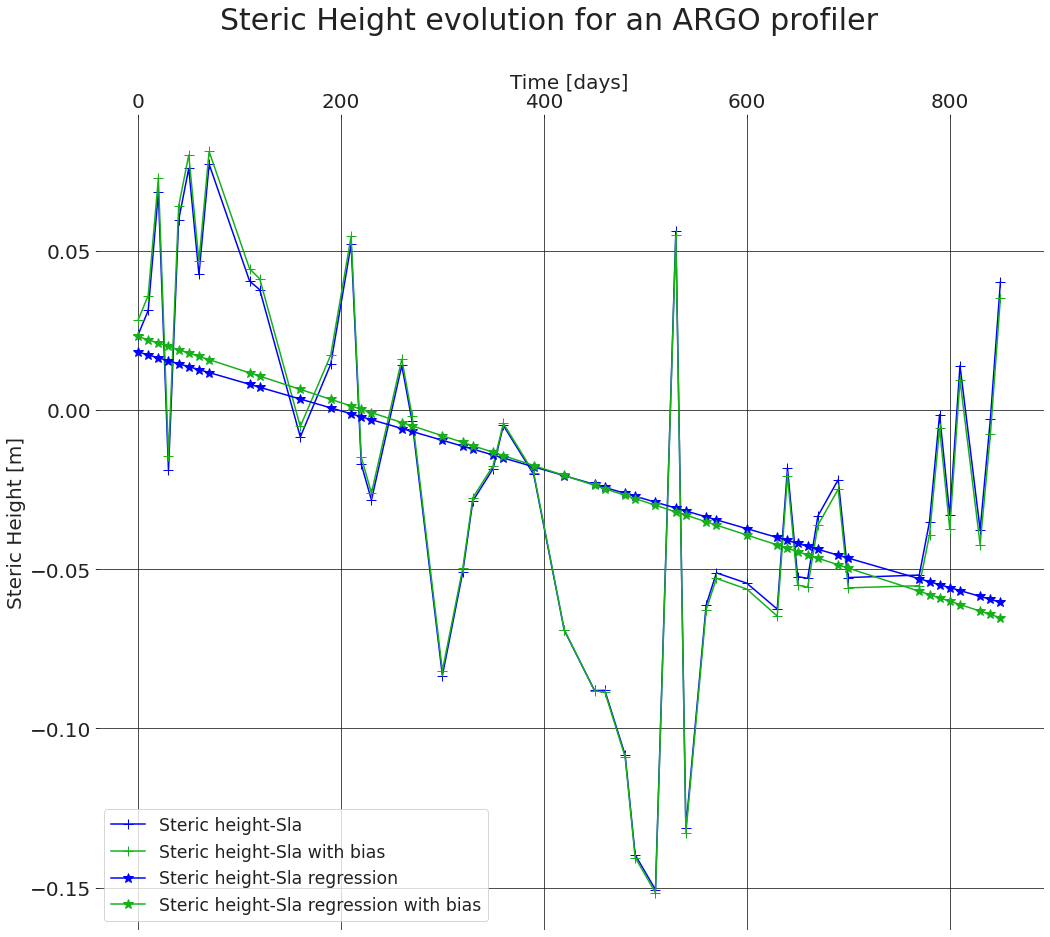

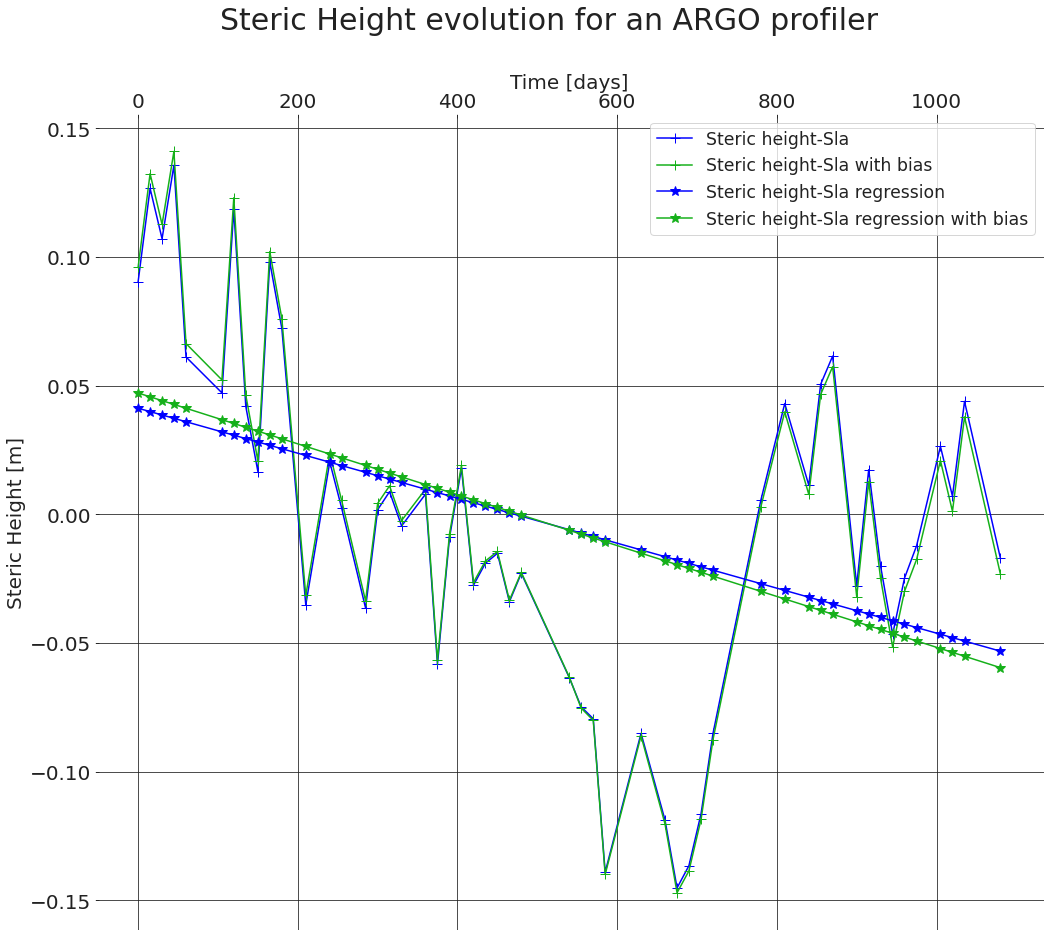

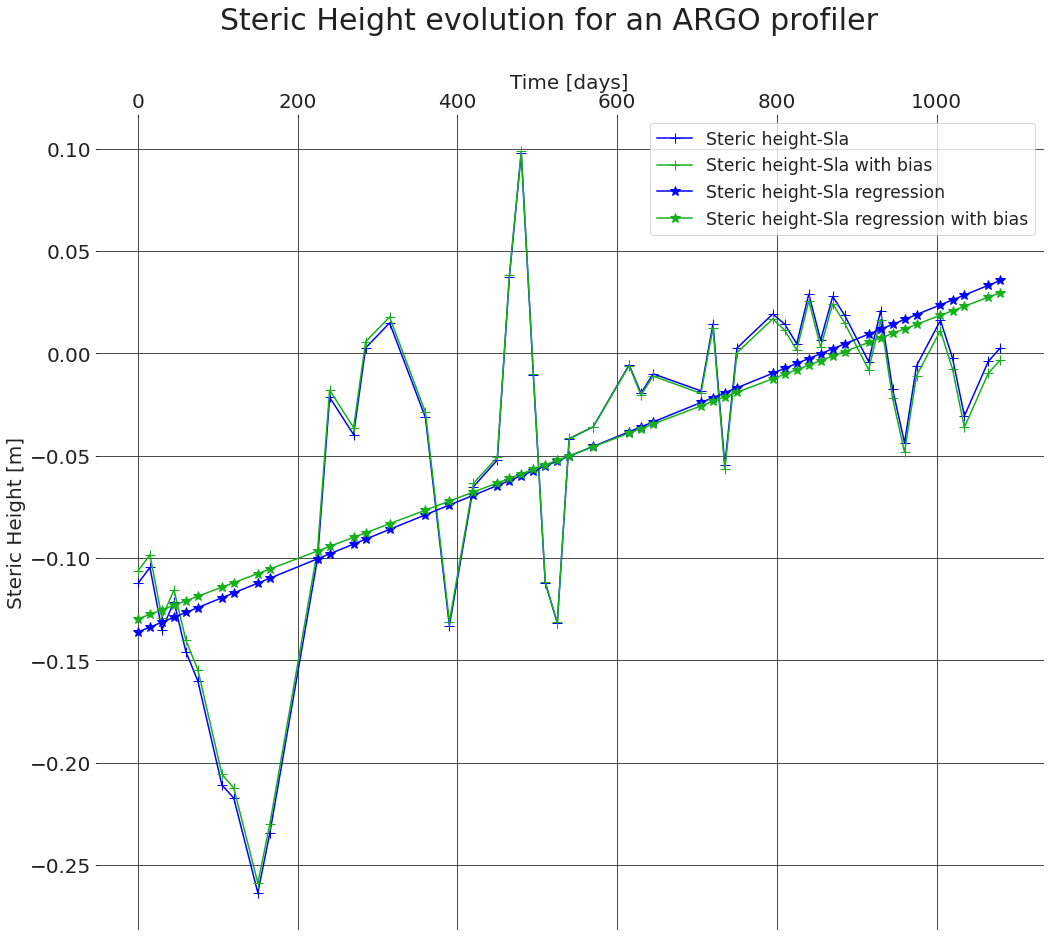

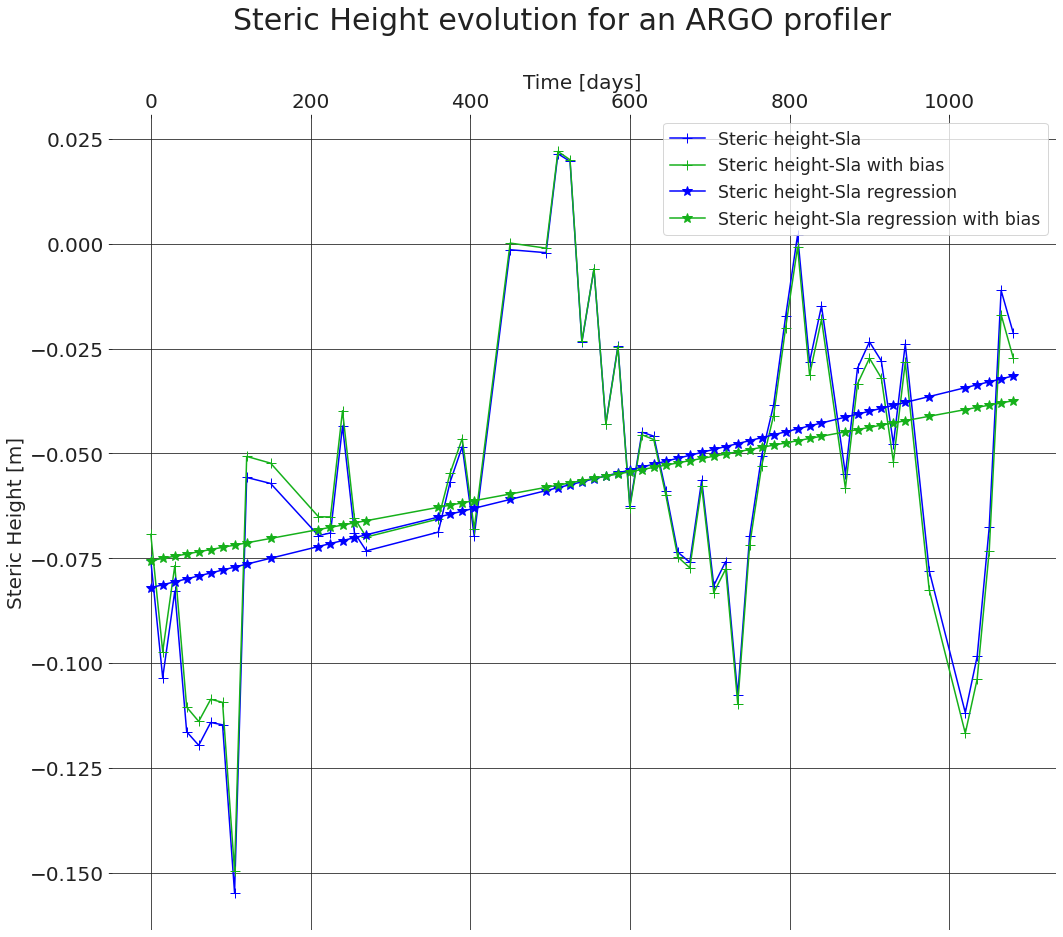

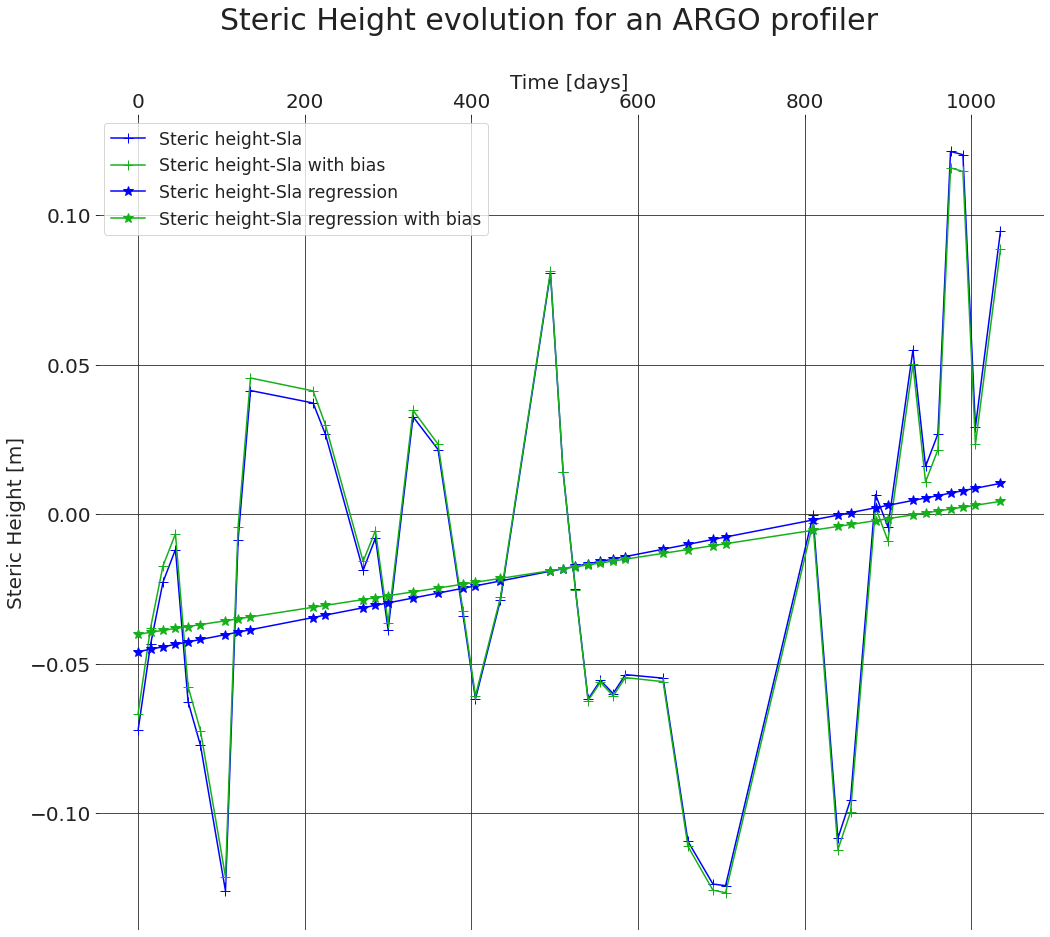

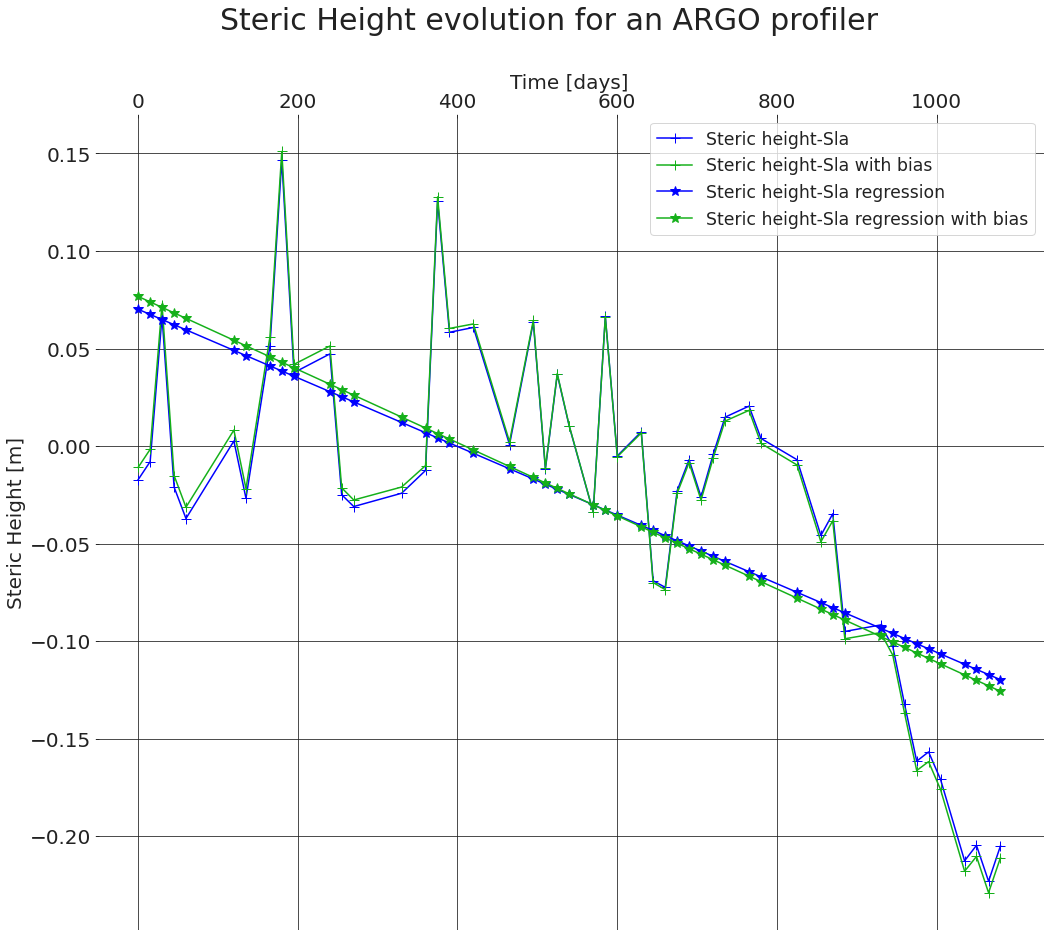

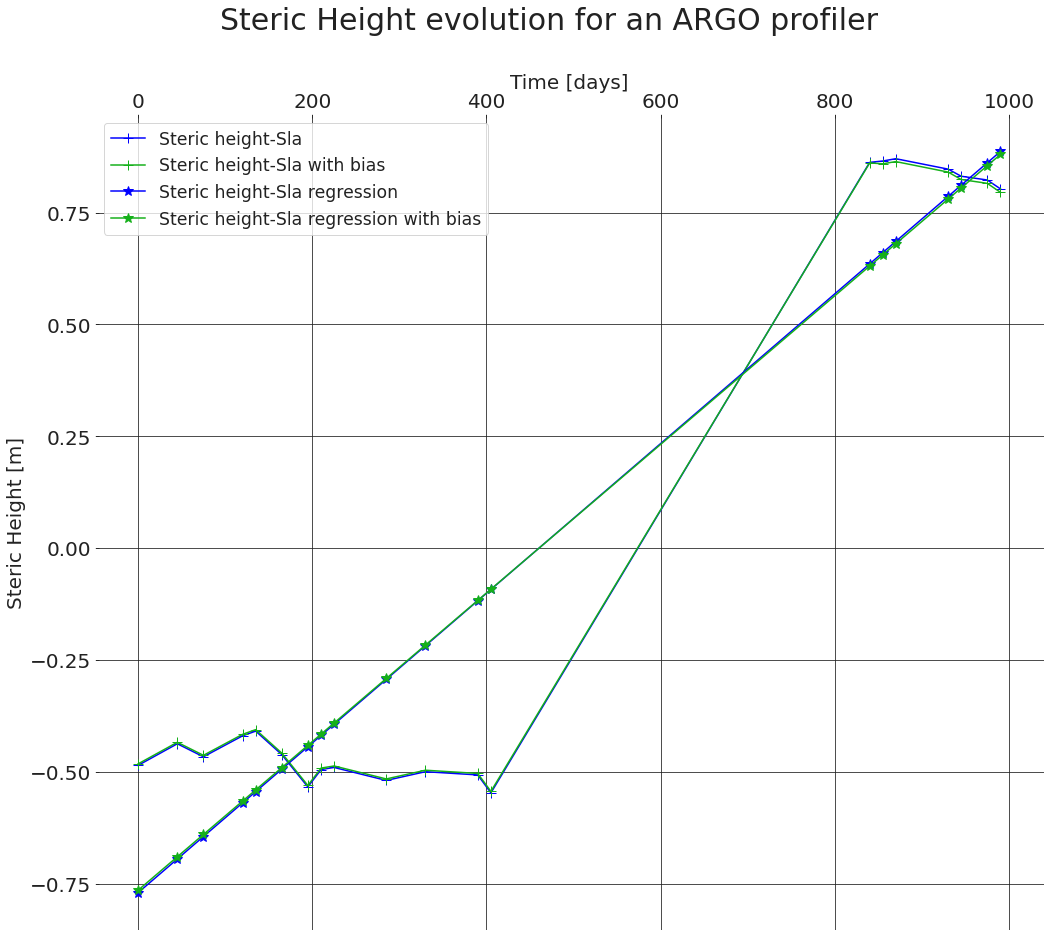

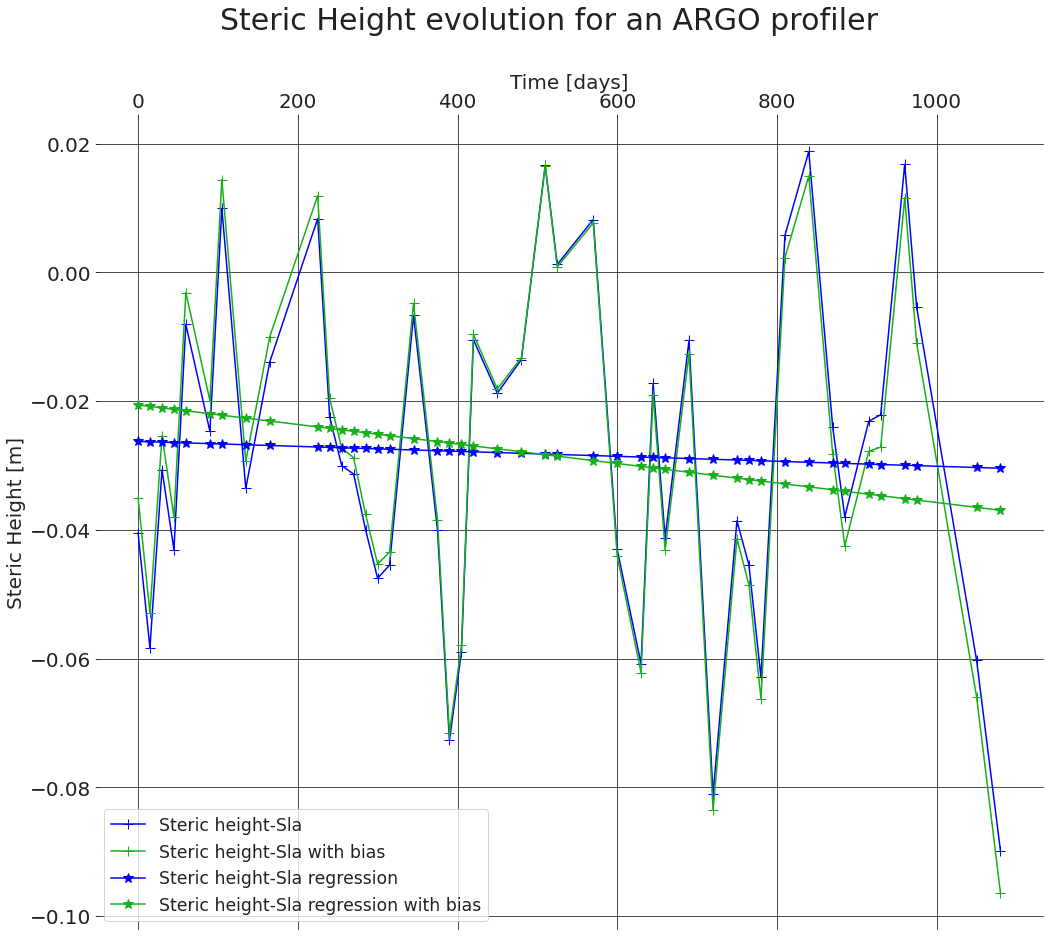

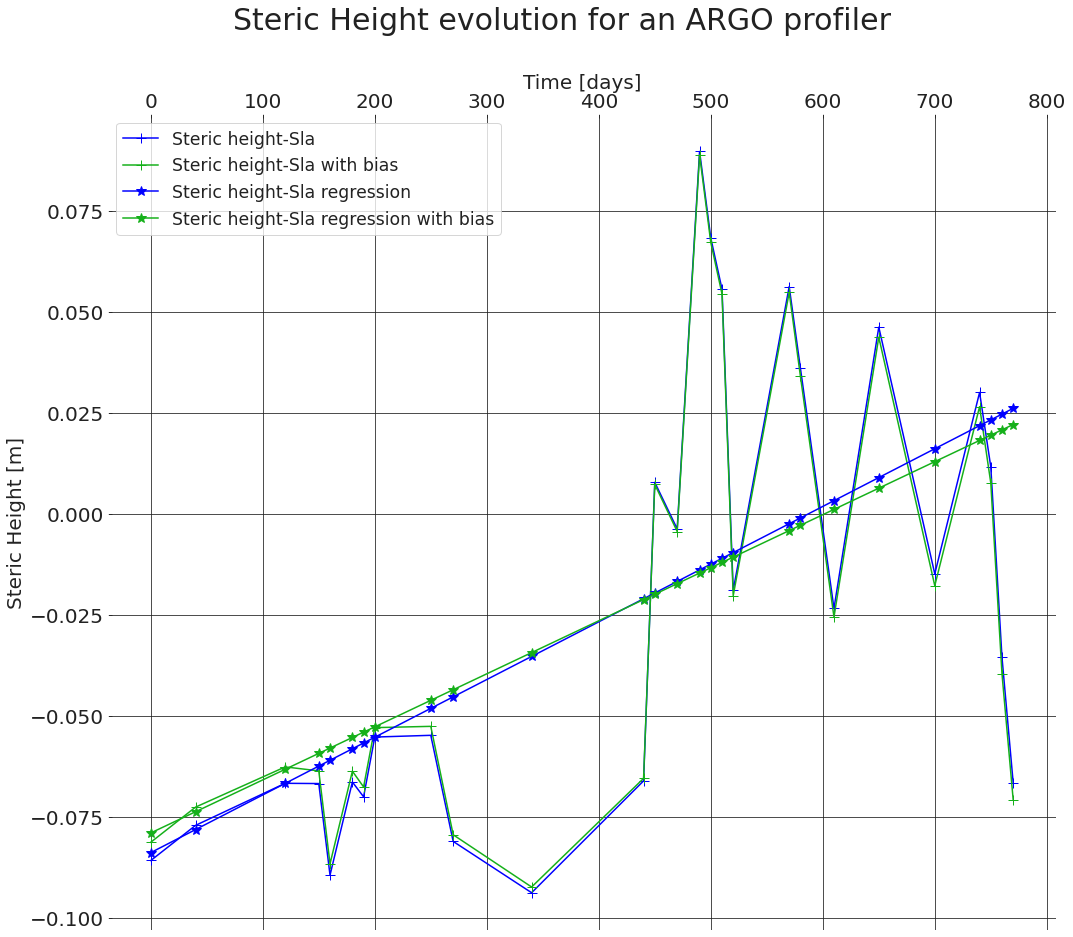

In [88]:
from matplotlib import cycler
colors = cycler('color',['#fc280f', '#5fdcff', '#f4ba26', '#85c54c', '#c6d7e0']) # colors for artists will be cycled from this list by default
plt.rc('figure', facecolor='#FFFFFF') # facecolor is background colour
plt.rc('axes', facecolor='#FFFFFF', edgecolor='#FFFFFF',
       axisbelow=True, grid=True, prop_cycle=colors) # "axisbelow" set axis ticks and gridlines are below all artists
plt.rc('grid', color='#222222', linestyle='solid')
plt.rc('xtick', direction='in', color='#222222')
plt.rc('ytick', direction='in', color='#222222')
plt.rc('patch', edgecolor='#e3e3e3')
plt.rc('lines', linewidth=1.5)


for i in range (14):
    fig = plt.figure(figsize=(17, 15))  # (w,h)
    ax = plt.subplot() 
    Raw_H_argo=P[i].steric_height[0]
    Raw_H_argo_b=P[i].steric_height[1]
    Raw_H_alt=P[i].altimetry_height
    
    H_argo=Raw_H_argo[~np.isnan(Raw_H_argo)]
    H_argo_b=Raw_H_argo_b[~np.isnan(Raw_H_argo)]
    H_alt=Raw_H_alt[~np.isnan(Raw_H_argo)]
    
    Mean=np.mean(H_argo)
    Mean_b=np.mean(H_argo_b)
    
    Time=(P[i].JULD-P[i].JULD[0])[~np.isnan(Raw_H_argo)]
    res_b = ss.stats.linregress(Time, H_argo_b-H_alt-Mean_b)
    res = ss.stats.linregress(Time, H_argo-H_alt-Mean)

    #ax.plot(Time, H_alt,color='#fd411e',label='Altimetry anomaly height', zorder=1, marker = '+')
    #ax.plot(Time, H_argo-H_argo_b,color='#0000FF',label='Steric height', zorder=1, marker = '+') 
    #ax.plot(Time, H_argo,color='#0000FF',label='Steric height', zorder=1, marker = '+') 
    #ax.plot(Time, H_argo_b,color='#15B01A',label='Steric height with bias', zorder=1, marker = '+') 
    ax.plot(Time, H_argo-H_alt-Mean,color='#0000FF',label='Steric height-Sla', zorder=1, marker = '+') 
    ax.plot(Time, H_argo_b-H_alt-Mean_b,color='#15B01A',label='Steric height-Sla with bias', zorder=1, marker = '+') 
    ax.plot(Time, res[1]+res[0]*Time,color='#0000FF',label='Steric height-Sla regression', zorder=1, marker = '*') 
    ax.plot(Time, res_b[1]+res_b[0]*Time,color='#15B01A',label='Steric height-Sla regression with bias', zorder=1, marker = '*') 
       
    plt.suptitle('Steric Height evolution for an ARGO profiler ', size=30, color='#222222')
    ax.set_ylabel('Steric Height [m]',color='#222222')
        
    ax.legend(labelcolor='#222222',fontsize='xx-large') 
    ax.set_xlabel('Time [days]',color='#222222')
    ax.grid(True, which='both')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    

